# Software Requirements Classification
## Decision Tree Classifier

In [62]:
import pandas as pd

df = pd.read_csv('software_requirements_extended.csv')
df['Type'] = df['Type'].apply(lambda x: 1 if x == 'FR' or x == 'F' else 0)

In [63]:

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem.porter import *

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nickbres/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/nickbres/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [64]:
# Pre-load stopwords to improve efficiency
STOPWORDS = set(stopwords.words("english"))

# Expanded pattern to potentially keep useful punctuation or additional cleaning
pattern_without_numbers = re.compile(r"[^a-zA-Z]")
pattern_with_numbers = re.compile(r"[^\w\d]")

def req_to_words(req, delete_stopwords, with_numbers, normalize_numbers,lemmatize = False,stemming = False,):
    """Convert requirement text into a sequence of 'clean' words"""
    # Convert to lower case
    text = req.lower()

    if with_numbers:
        pattern = pattern_with_numbers
    else:
        pattern = pattern_without_numbers

    if with_numbers and normalize_numbers:
        text = re.sub(r'\b\d+\b', 'num', text)

    # Remove unwanted characters
    text = re.sub(pattern, " ", text)

    # Tokenize
    words = text.split()

    # Remove stopwords
    if delete_stopwords:
        words = [w for w in words if w not in STOPWORDS]

    # Apply lemmatization or stemming
    if lemmatize:
        words = [ WordNetLemmatizer().lemmatize(w) for w in words]
    elif stemming: # Stemming
        words = [PorterStemmer().stem(w) for w in words]

    # join the words back into one string
    clean_req = " ".join(words)

    return clean_req

### Vectorization

## Model

In [65]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

def find_best_hyperparameters(X,y):
    param_grid = {
        'max_depth': [None, 10, 20, 30, 40, 50],  # None means unlimited depth
        'min_samples_split': [2, 5, 10, 20],  # The minimum number of samples required to split
        'min_samples_leaf': [1, 2, 5, 10],  # The minimum number of samples required at a leaf node
        'criterion': ['gini', 'entropy']  # The function to measure the quality of a split
    }
    
    grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, n_jobs=-1, scoring='accuracy', verbose=2)
    
    grid_search.fit(X, y)
    
    # print("Best parameters:", grid_search.best_params_)
    # print("Best cross-validated score:", grid_search.best_score_)
    return grid_search.best_params_, grid_search.best_score_

In [66]:
import pandas as pd

def draw_important_features_for_tree(model, vectorizer):
    # Get the feature importances from the model
    feature_importances = model.feature_importances_

    # Get the feature names from the vectorizer
    feature_names = vectorizer.get_feature_names_out()

    # Zip feature importances with names and create a DataFrame
    importance_df = pd.DataFrame(list(zip(feature_names, feature_importances)), columns=['Feature', 'Importance'])

    # Sort the DataFrame by the Importance column in descending order
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Plot the top 10 features
    plt.figure(figsize=(10, 8))
    plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10])
    plt.gca().invert_yaxis()  # Invert the y-axis to show the most important feature at the top
    plt.xlabel('Feature Importance')
    plt.title('Top 10 Features')
    plt.show()


In [67]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def draw_confusion_matrix(y_test, y_pred):
    # Compute the normalized confusion matrix
    cm_normalized = confusion_matrix(y_test, y_pred, normalize='true')

    # Convert to percentage
    cm_percentage = cm_normalized * 100

    # Visualize the confusion matrix as percentages
    plt.figure(figsize=(10,7))
    sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=['Non-Functional', 'Functional'], yticklabels=['Non-Functional', 'Functional'])
    plt.title('Confusion Matrix (Percentage)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report

def run_experiment(df, preprocessing_params, isVisualize = True):
    """
    Run an experiment to train a logistic regression model with the best hyperparameters found using grid search.
    Evaluates the model using cross-validation and on a test set, and displays the model's important features and confusion matrix.

    Parameters:
    - df: DataFrame containing the dataset.
    - preprocessing_params: Dictionary containing preprocessing parameters (lemmatize, delete_stopwords, normalize_numbers, etc.).
    - ngram_range: Tuple indicating the range of n-grams to be used in vectorization.
    """
    # Extract preprocessing parameters
    lemmatize = preprocessing_params.get('lemmatize', False)
    stemming = preprocessing_params.get('stemming', False)
    delete_stopwords = preprocessing_params.get('delete_stopwords', True)
    with_numbers = preprocessing_params.get('with_numbers', True)
    normalize_numbers = preprocessing_params.get('normalize_numbers', True)

    # Prepare the data
    y = df['Type']
    # Preprocess the requirements to convert them into 'clean' words
    X = [req_to_words(req, lemmatize=lemmatize,stemming= stemming, delete_stopwords=delete_stopwords, with_numbers=with_numbers, normalize_numbers=normalize_numbers) for req in df['Requirement']]


    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Vectorize the text
    vectorizer = TfidfVectorizer()
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)

    # Find the best model parameters
    best_params,best_cross = find_best_hyperparameters(X_train, y_train)

    # Create the best estimator
    best_estimator = DecisionTreeClassifier(**best_params)

    # Train the best estimator on the full training set
    best_estimator.fit(X_train, y_train)

    # Evaluate on the test set
    y_pred = best_estimator.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    if isVisualize:
        print(f'Accuracy: {test_accuracy * 100:.2f}%')

        # Detailed performance report
        print(classification_report(y_test, y_pred))

        # Additional evaluations
        draw_important_features_for_tree(best_estimator, vectorizer)
        draw_confusion_matrix(y_test, y_pred)

    return best_estimator, vectorizer, best_cross

### Experimenting 

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Accuracy: 83.33%
              precision    recall  f1-score   support

           0       0.81      0.82      0.81       131
           1       0.85      0.85      0.85       163

    accuracy                           0.83       294
   macro avg       0.83      0.83      0.83       294
weighted avg       0.83      0.83      0.83       294


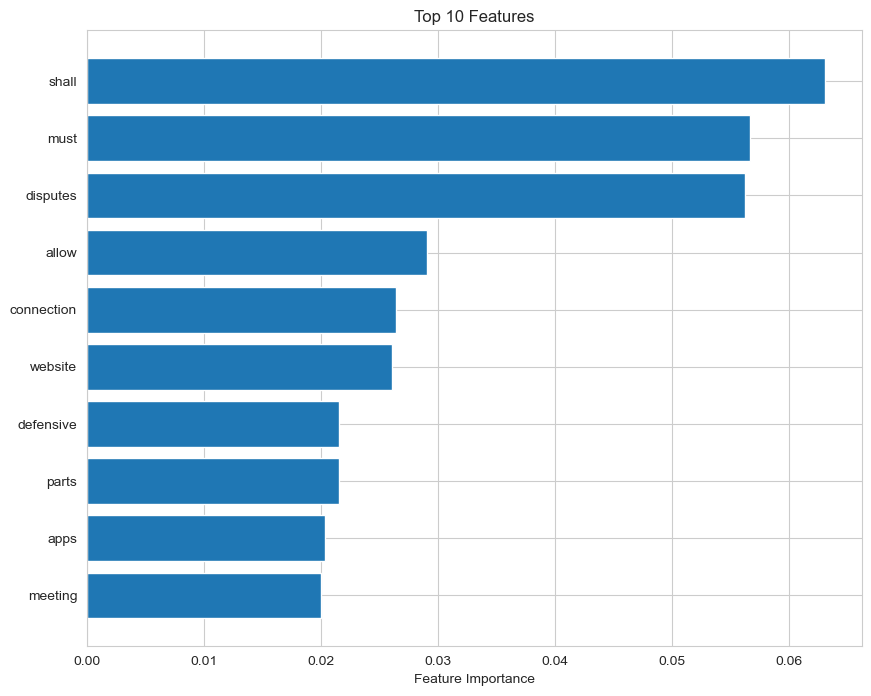

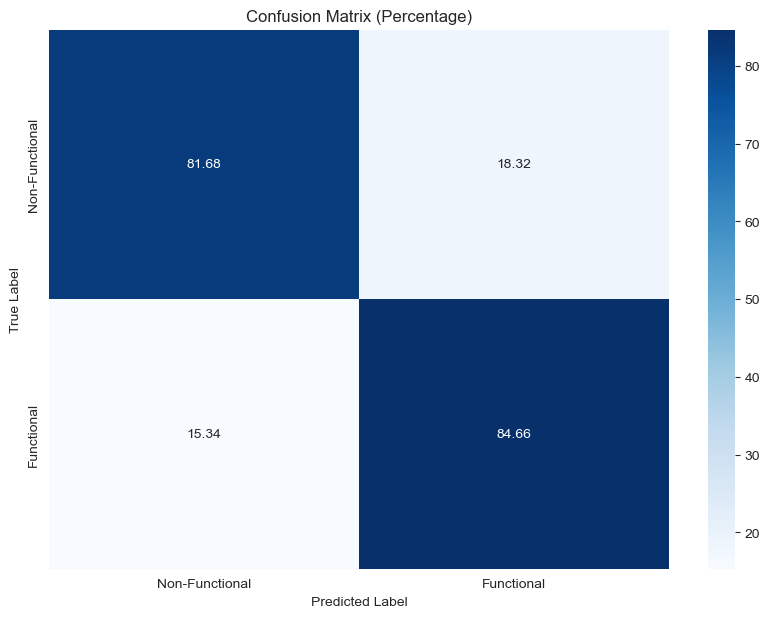

In [69]:
preprocessing_params = {
    'lemmatize': False, # use lemmatization false by default
    'stemming': False, # use stemming false by default
    'delete_stopwords': True, # delete stopwords like 'the', 'and', etc.
    'with_numbers': True, # keep numbers or not
    'normalize_numbers': False # normalize numbers to a single token (will only work if with_numbers is True)
}
model, vectorizer,cross = run_experiment(df, preprocessing_params)

In [70]:
from itertools import product

def find_best_cleaning_params(df):
    """
    Try all combinations of cleaning parameters and return the combination
    with the highest cross-validation score.
    """
    best_score = 0
    best_params = {}

    # Generate all possible combinations of boolean values for the parameters
    # There are five parameters, so there are 2^5 = 32 possible combinations
    for lemmatize, stemming, delete_stopwords, with_numbers, normalize_numbers in product([True, False], repeat=5):

        # Skip invalid combinations where we attempt to normalize numbers when they are not included
        if normalize_numbers and not with_numbers:
            continue

        # Set up the preprocessing parameters
        preprocessing_params = {
            'lemmatize': lemmatize,
            'stemming': stemming,
            'delete_stopwords': delete_stopwords,
            'with_numbers': with_numbers,
            'normalize_numbers': normalize_numbers
        }

        # Run the experiment with the current combination of parameters
        _, _, best_cross = run_experiment(df, preprocessing_params, isVisualize = False)

        # Update best score and parameters if current score is higher
        if best_cross > best_score:
            best_score = best_cross
            best_params = preprocessing_params

    return best_params, best_score

In [71]:
best_params, best_score = find_best_cleaning_params(df)
print("Best parameters:", best_params)
print("Best cross-validation score:", best_score)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Fitting 5 folds for each of 192 candidates, totalling 960 fits
Fitting 5 folds for each of 192 candidates, totalling 960 fits
Fitting 5 folds for each of 192 candidates, totalling 960 fits
Fitting 5 folds for each of 192 candidates, totalling 960 fits
Fitting 5 folds for each of 192 candidates, totalling 960 fits
Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=20; total time=   0.0s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=None, min_sample

### With AdaBoost

In [72]:
from sklearn.ensemble import AdaBoostClassifier

In [73]:
param_grid = {
    'n_estimators': [30,50,100,150],
    'learning_rate': [0.01,0.1, 0.5, 1, 2, 5]
}

grid_search = GridSearchCV(AdaBoostClassifier(
    estimator=DecisionTreeClassifier(
        criterion='gini',
        max_depth=50,
        min_samples_leaf=1,
        min_samples_split=2
    )
), param_grid, cv=5, n_jobs=-1, scoring='accuracy', verbose=2)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validated score:", grid_search.best_score_)

NameError: name 'X_train' is not defined

In [ ]:
ada_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(
        criterion='gini',
        max_depth=30,
        min_samples_leaf=1,
        min_samples_split=5
    ),
    n_estimators=100,
    learning_rate=2
)
ada_model.fit(X_train, y_train)

In [ ]:
y_pred = ada_model.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test,y_pred) * 100:.2f}%')
print(classification_report(y_test, y_pred))

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Compute the normalized confusion matrix
cm_normalized = confusion_matrix(y_test, y_pred, normalize='true')

# Convert to percentage
cm_percentage = cm_normalized * 100

# Visualize the confusion matrix as percentages
plt.figure(figsize=(10,7))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=['Non-Functional', 'Functional'], yticklabels=['Non-Functional', 'Functional'])
plt.title('Confusion Matrix (Percentage)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
def predict_req(req, expected, model, vectorizer):
    df = pd.DataFrame([req], columns=['Requirement'])
    X = [' '.join(req_to_words(req)) for req in df['Requirement']]
    X = vectorizer.transform(X)

    prediction = model.predict(X)
    predicted_label = 'Functional' if prediction[0] == 1 else 'Non-Functional'
    success = predicted_label == expected

    return predicted_label, success


In [ ]:
def summarize_predictions(examples, model, vectorizer):
    results = []
    for req, expected_label in examples:
        predicted_label, success = predict_req(req, expected_label, model, vectorizer)
        results.append({
            'Requirement': req,
            'Expected Label': expected_label,
            'Predicted Label': predicted_label,
            'Success': success
        })
    return pd.DataFrame(results)

In [ ]:
examples = [
    ("The system shall provide a login form that accepts a username and password.", 'Functional'),
    ("The application must ensure that response times are less than 2 seconds under normal load conditions.", 'Non-Functional'),
    ("All user passwords shall be encrypted before saving to the database.", 'Functional'),
    ("The software should be compatible with the Windows 10 operating system.", 'Non-Functional'),
    ("The interface shall refresh when new data is available.", 'Functional'),
    ("The product shall comply with international accessibility standards.", 'Non-Functional'),
    ("Database backup shall occur every 24 hours automatically.", 'Functional'),
    ("The system shall support a minimum of 500 concurrent user connections.", 'Functional'),
    ("The system’s mean time to failure shall be at least 10,000 hours.", 'Non-Functional'),
    ("Users must be able to complete the primary workflow in less than three minutes.", 'Non-Functional'),
    ("User settings must be retained for at least one year without login.", 'Non-Functional'),
    ("The system must support multi-language interfaces.", 'Functional'),
    ("Ensure data integrity during transaction processing.", 'Functional'),
    ("The application should load the user dashboard within 3 seconds.", 'Non-Functional'),
    ("Support data export to CSV and PDF formats.", 'Functional'),
    ("Must be compatible with both iOS and Android operating systems.", 'Non-Functional'),
    ("Implement two-factor authentication for user logins.", 'Functional'),
    ("The application must be available 99.9% of the time.", 'Non-Functional'),
    ("Automatically log out users after 30 minutes of inactivity.", 'Functional'),
    ("The system must scale to support up to 10,000 users simultaneously.", 'Non-Functional'),
    ("Provide a way to recover forgotten passwords securely.", 'Functional'),
    ("The system must encrypt sensitive data both at rest and in transit.", 'Non-Functional'),
    ("Support for user roles including admin, editor, and viewer.", 'Functional'),
    ("Ensure the application interface adheres to the latest web accessibility guidelines.", 'Non-Functional'),
    ("The software must be installable on both Windows and MacOS.", 'Non-Functional'),
    ("Offer a search function that returns results within 2 seconds.", 'Functional'),
    ("The mobile app should use no more than 50MB of data per hour of activity.", 'Non-Functional'),
    ("The platform must integrate seamlessly with third-party email services.", 'Functional'),
    ("User feedback must be addressed and incorporated within two release cycles.", 'Non-Functional'),
    ("Provide detailed logging of user actions to support auditing requirements.", 'Functional')
]


In [ ]:
summary = summarize_predictions(examples, ada_model, vectorizer)
summary

In [ ]:
import plotly.express as px

fig = px.pie(summary, names='Success', title ='Success of the model on my examples')
fig.show()